# LSTM, One day at a time!
In this Notebook we'll see how the Pytorch LSTM block allows us to pass it the whole data sequence at once. The LSTM block will very quickly process the sequence for us, without having to use a slow Python for loop. Instead of providing a sequence of data ast each time-step (like previous notebooks) we'll simply provide the LSTM a single days worth of data at a time.

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/LSTM_Cell.svg/2880px-LSTM_Cell.svg.png">](LSTM)
<br>
[Corresponding Tutorial Video](https://youtu.be/lyUT6dOARGs)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm
from Dataset import WeatherDataset

In [2]:
# Path to the CSV file containing the weather dataset
dataset_file = "../data/weather.csv"

# Define the date to split the dataset into training and testing sets
split_date = pd.to_datetime('2023-01-01')

# Number of days in the input sequence
day_range = 30

# Number of days the MLP will take as input
days_in = 14

# Ensure that the total number of days in the input sequence is larger than the MLP input size
assert day_range > days_in, "The total day range must be larger than the input days for the MLP"

# Define the hyperparameters for training the model
learning_rate = 1e-4  # Learning rate for the optimizer
nepochs = 500  # Number of training epochs
batch_size = 32  # Batch size for training

# Create training dataset
# This will load the weather data, consider sequences of length day_range,
# and split the data such that data before split_date is used for training
dataset_train = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="train")

# Create testing dataset
# This will load the weather data, consider sequences of length day_range,
# and split the data such that data after split_date is used for testing
dataset_test = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="test")

In [3]:
print(f'Number of training examples: {len(dataset_train)}')
print(f'Number of testing examples: {len(dataset_test)}')

Number of training examples: 3465
Number of testing examples: 397


In [4]:
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)

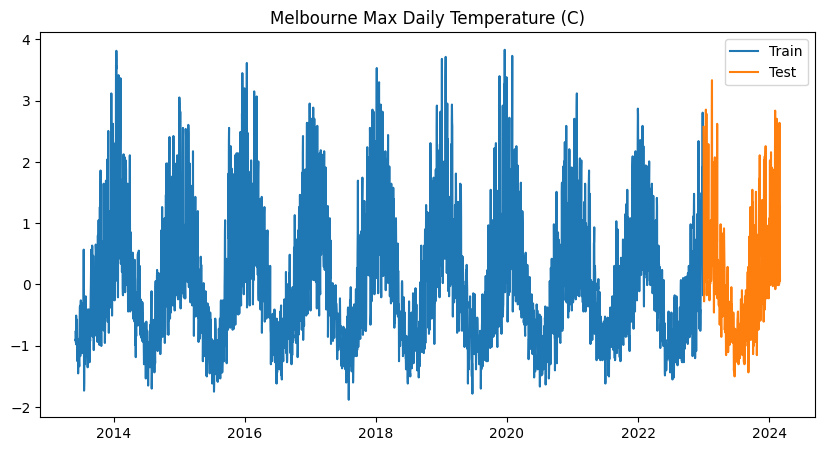

In [5]:
fig = plt.figure(figsize=(10, 5))
_ = plt.title("Melbourne Max Daily Temperature (C)")

_ = plt.plot(dataset_train.dataset.index, dataset_train.dataset.values[:, 1])
_ = plt.plot(dataset_test.dataset.index, dataset_test.dataset.values[:, 1])

_ = plt.legend(["Train", "Test"])
# Note:see here how we can just directly access the data from the dataset class

## Create LSTM Model
In this Notebook, we'll explore how to leverage PyTorch's LSTM block to process entire data sequences efficiently. Instead of providing data at each time-step, as done in previous notebooks, we'll feed the LSTM a single day's data at a time.

In [6]:
# Define our network class using nn.Module
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        # Define layers for the MLP block
        self.norm1 = nn.LayerNorm(input_size)
        self.fc1 = nn.Linear(input_size, input_size//2)
        self.norm2 = nn.LayerNorm(input_size//2)
        self.fc2 = nn.Linear(input_size//2, output_size)
        self.fc3 = nn.Linear(input_size, output_size)
        self.act = nn.ELU()

    def forward(self, x):
        # Forward pass through the MLP block
        x = self.act(self.norm1(x))
        skip = self.fc3(x)  # Skip connection
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        return x + skip

# Define the LSTM-based network
class LSTM(nn.Module):
    def __init__(self, seq_len, output_size, num_blocks=1, hidden_size=128):
        super(LSTM, self).__init__()
        # Define layers for input MLP, LSTM, residual blocks, and output linear layer
        self.input_mlp = nn.Sequential(nn.Linear(seq_len, 4 * seq_len),
                                       nn.ELU(),
                                       nn.Linear(4 * seq_len, hidden_size))
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        blocks = [ResBlockMLP(hidden_size, hidden_size) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.act = nn.ELU()

    def forward(self, input_seq, hidden_in, mem_in):
        # Pass input sequence through the input MLP
        input_vec = self.input_mlp(input_seq)
        
        # Pass the input MLP output through the LSTM block
        output, (hidden_out, mem_out) = self.lstm(input_vec, (hidden_in, mem_in))
        
        # Pass the LSTM output through residual blocks
        x = self.act(self.res_blocks(output))
        
        # Pass the output of the residual blocks through the final linear layer
        return self.fc_out(x), hidden_out, mem_out


In [7]:
# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

hidden_size = 128

# Create the LSTM model
weather_lstm = LSTM(seq_len=2, output_size=2, hidden_size=hidden_size).to(device)

# Initialize the optimizer with Adam and specified learning rate
optimizer = optim.Adam(weather_lstm.parameters(), lr=learning_rate)

# Define the loss function as Mean Squared Error
loss_fn = nn.MSELoss()

# Initialize a list to log training losses
training_loss_logger = []

In [8]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in weather_lstm.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 167002 (Approximately 0 Million) Parameters!


## Training

In [9]:
# Run training loop for each epoch
for epoch in trange(nepochs, desc="Epochs", leave=False):
    # Set the model to training mode
    weather_lstm.train()
    
    # Iterate through the training data loader
    for day, month, data_seq in tqdm(data_loader_train, desc="Training", leave=False):
        
        # Pass the whole sequence of data at once
        seq_block = data_seq[:, :-1].to(device)
        target_seq_block = data_seq[:, 1:].to(device)
        
        # Initialize hidden state and memory
        hidden = torch.zeros(1, data_seq.shape[0], hidden_size, device=device)
        memory = torch.zeros(1, data_seq.shape[0], hidden_size, device=device)

        # Pass the input sequence through the LSTM
        data_pred, hidden, memory = weather_lstm(seq_block, hidden, memory)
        
        # Calculate the loss
        loss = loss_fn(data_pred, target_seq_block)
        
        # Perform backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log the training loss
        training_loss_logger.append(loss.item())

Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

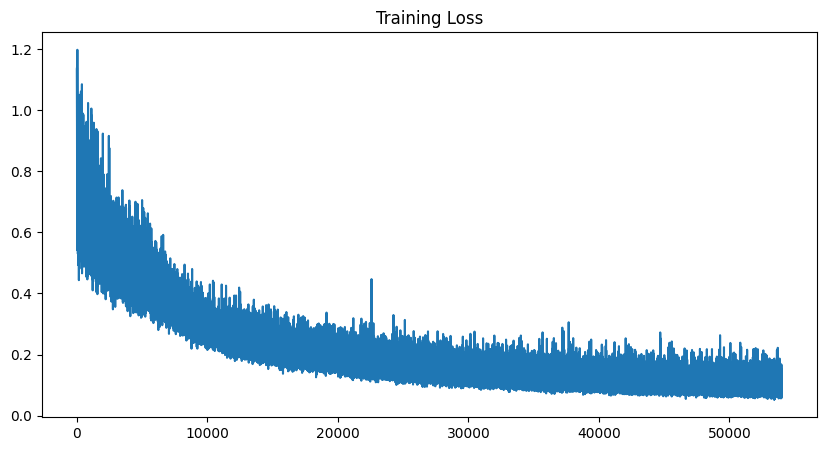

In [10]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger)
_ = plt.title("Training Loss")

## Testing

In [11]:
# Convert test dataset to tensor
data_tensor = torch.FloatTensor(dataset_test.dataset.values)

# Initialize a list to store predictions
log_predictions = []

# Set the model to evaluation mode
weather_lstm.eval()

# Specify the length of the input sequence
len_input = 30

# Run prediction loop with no gradients
with torch.no_grad():
    # Initialize the input sequence with the first len_input data points
    seq_block = data_tensor[:len_input].unsqueeze(0).to(device)
    
    # Initialize hidden state and memory
    hidden = torch.zeros(1, seq_block.shape[0], hidden_size, device=device)
    memory = torch.zeros(1, seq_block.shape[0], hidden_size, device=device)
    
    # Iterate over the remaining data points
    for i in range(data_tensor.shape[0] - len_input):
        # Predict the next data point
        data_pred, hidden, memory = weather_lstm(seq_block, hidden, memory)
    
        # Update the input sequence with the predicted data point
        seq_block = data_pred[:, -1:, :]
        
        # Append the prediction to the list
        log_predictions.append(data_pred[:, -1, :].cpu())
        
# Concatenate all predictions
predictions_cat = torch.cat(log_predictions)

# Denormalize the predictions and original data
un_norm_predictions = (predictions_cat * dataset_test.std) + dataset_test.mean
un_norm_data = (data_tensor * dataset_test.std) + dataset_test.mean
un_norm_data = un_norm_data[len_input:]

In [12]:
test_mse = (un_norm_data - un_norm_predictions).pow(2).mean().item()
print("Test MSE value %.2f" % test_mse)

Test MSE value 44.91


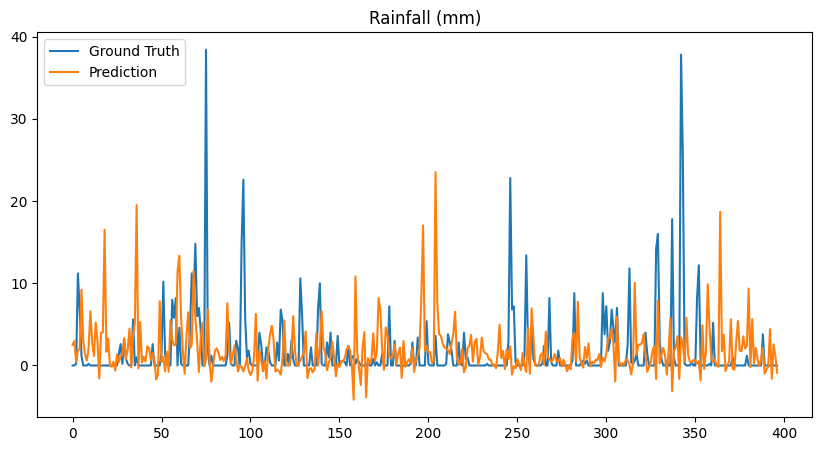

In [13]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(un_norm_data[:, 0])
_ = plt.plot(un_norm_predictions[:, 0])
_ = plt.title("Rainfall (mm)")

_ = plt.legend(["Ground Truth", "Prediction"])

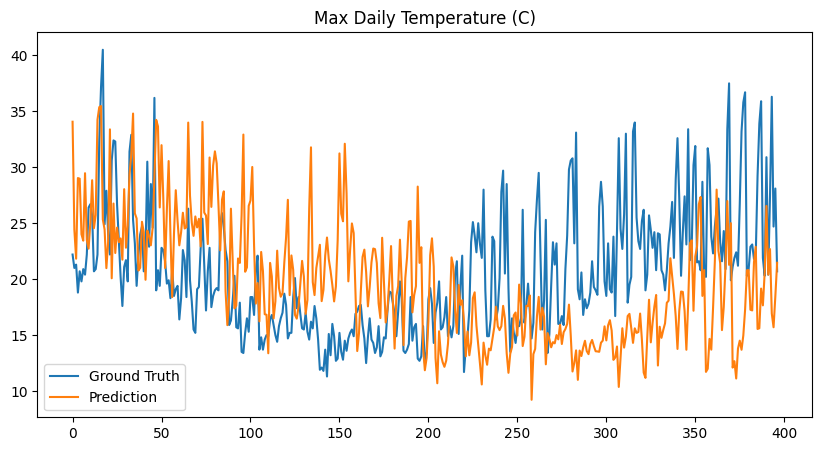

In [14]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(un_norm_data[:, 1])
_ = plt.plot(un_norm_predictions[:, 1])
_ = plt.title("Max Daily Temperature (C)")

_ = plt.legend(["Ground Truth", "Prediction"])